## echoFace - Product Recommendation Model
Multimodal User Authentication and Product Recommendation System

This notebook implements the Product Recommendation component that predicts
which product category a customer is likely to purchase based on their
social media engagement and transaction history.

In [1]:
# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                           confusion_matrix, log_loss)
from xgboost import XGBClassifier
import joblib

# Check sklearn version
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n" + "=" * 80)
print("echoFace - Product Recommendation Model")
print("=" * 80)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

Matplotlib is building the font cache; this may take a moment.


scikit-learn version: 1.6.1

echoFace - Product Recommendation Model
Timestamp: 2025-11-13 17:37:51


In [10]:
# ============================================================================
# 2. HELPER FUNCTIONS
# ============================================================================

def load_data(filepath):
    """Load dataset from CSV file."""
    df = pd.read_csv(filepath)
    print(f"✓ Loaded {filepath}")
    print(f"  Shape: {df.shape}")
    return df

def display_categorical(df):
    """Display distribution of categorical variables."""
    print("\n--- Categorical Variable Distribution ---")
    print("\nProduct Category Distribution:")
    display(df['product_category'].value_counts())
    print("\nSocial Media Platform Distribution:")
    display(df['social_media_platform'].value_counts())
    print("\nReview Sentiment Distribution:")
    display(df['review_sentiment'].value_counts())

def data_preprocessing(df, le):
    """
    Preprocess the merged dataset:
    - Extract date features
    - Drop irrelevant columns
    - Encode categorical variables
    """
    print("\n--- Data Preprocessing ---")

    # Create temporal features from purchase_date
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['month'] = df['purchase_date'].dt.month
    df['day'] = df['purchase_date'].dt.day
    df['weekday'] = df['purchase_date'].dt.day_of_week
    df['isweekend'] = (df['weekday'] >= 5).astype(int)

    # Drop columns not needed for prediction
    df.drop(columns='purchase_date', inplace=True)
    df = df.drop(['customer_id', 'transaction_id', 'year'], axis=1)

    # Get numerical columns (before encoding)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('isweekend')

    # Label encode target variable (product_category)
    df['product_category'] = le.fit_transform(df['product_category'])

    # Ordinal encoding for review sentiment
    sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    df['review_sentiment'] = df['review_sentiment'].map(sentiment_mapping)

    # One-hot encode social media platform
    df = pd.get_dummies(df, columns=['social_media_platform'], dtype=int)

    # Print label mapping
    print("\n✓ Product Category Encoding:")
    for idx, category in enumerate(le.classes_):
        print(f"  {category} = {idx}")

    return df, numeric_cols

def prep_data(df):
    """Prepare features and target, split into train/test sets."""
    X = df.drop('product_category', axis=1)
    y = df['product_category']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f'\n--- Train-Test Split ---')
    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')

    return X, y, X_train, X_test, y_train, y_test

def save_model_artifacts(model, scaler, le, final_columns, numeric_cols, output_dir='../models/product/'):
    """Save all model artifacts needed for prediction."""
    os.makedirs(output_dir, exist_ok=True)

    joblib.dump(model, os.path.join(output_dir, 'product_recommendation_model.pkl'))
    joblib.dump(scaler, os.path.join(output_dir, 'product_model_scaler.pkl'))
    joblib.dump(le, os.path.join(output_dir, 'product_model_encoder.pkl'))
    joblib.dump(final_columns, os.path.join(output_dir, 'product_model_columns.pkl'))
    joblib.dump(numeric_cols, os.path.join(output_dir, 'product_model_numeric_cols.pkl'))

    print(f"\n✓ All model artifacts saved to '{output_dir}'")
    print("  - product_recommendation_model.pkl")
    print("  - product_model_scaler.pkl")
    print("  - product_model_encoder.pkl")
    print("  - product_model_columns.pkl")
    print("  - product_model_numeric_cols.pkl")

In [8]:
# ============================================================================
# 3. DATA LOADING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: DATA LOADING AND MERGING")
print("=" * 80)

# Load individual datasets
df_social = load_data('/Users/edine.mugisha/Documents/School/echoFace/data/customer-info/customer_social_profiles - customer_social_profiles.csv')
df_transactions = load_data('/Users/edine.mugisha/Documents/School/echoFace/data/customer-info/customer_transactions - customer_transactions.csv')

print("\n--- Social Profiles Sample ---")
display(df_social.head())

print("\n--- Transactions Sample ---")
display(df_transactions.head())


STEP 1: DATA LOADING AND MERGING
✓ Loaded /Users/edine.mugisha/Documents/School/echoFace/data/customer-info/customer_social_profiles - customer_social_profiles.csv
  Shape: (155, 5)
✓ Loaded /Users/edine.mugisha/Documents/School/echoFace/data/customer-info/customer_transactions - customer_transactions.csv
  Shape: (150, 6)

--- Social Profiles Sample ---


,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral



--- Transactions Sample ---


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [14]:
# ============================================================================
# 4. DATA MERGING
# ============================================================================

print("\n--- Merging Datasets ---")
print("\nMerging strategy:")
print("  1. Use customer_id_new from social profiles")
print("  2. Use customer_id_legacy from transactions")
print("  3. Match customer identifiers after cleaning")

# Rename columns for consistency
df_social_renamed = df_social.rename(columns={'customer_id_new': 'customer_id'})
df_transactions_renamed = df_transactions.rename(columns={'customer_id_legacy': 'customer_id'})

# Check ID formats before merging
print("\n--- Investigating ID Formats ---")
print(f"Social Profile ID sample: {df_social_renamed['customer_id'].head(5).tolist()}")
print(f"Transaction ID sample: {df_transactions_renamed['customer_id'].head(5).tolist()}")

# Clean IDs - Remove 'A' prefix from social profiles if present
if df_social_renamed['customer_id'].astype(str).str.contains('A').any():
    print("\n⚠ Detected 'A' prefix in social profile IDs - removing for merge")
    df_social_renamed['customer_id'] = df_social_renamed['customer_id'].astype(str).str.replace('A', '', regex=False)

# Ensure both are strings
df_social_renamed['customer_id'] = df_social_renamed['customer_id'].astype(str)
df_transactions_renamed['customer_id'] = df_transactions_renamed['customer_id'].astype(str)

# Check overlap before merge
social_ids = set(df_social_renamed['customer_id'])
transaction_ids = set(df_transactions_renamed['customer_id'])
overlap = social_ids.intersection(transaction_ids)
print(f"\n✓ Found {len(overlap)} matching customer IDs")

# Merge datasets
df_merged = pd.merge(
    df_transactions_renamed, 
    df_social_renamed, 
    on='customer_id', 
    how='inner'
)

print(f"\n✓ Datasets merged successfully!")
print(f"  Merged dataset shape: {df_merged.shape}")
print(f"  Unique customers: {df_merged['customer_id'].nunique()}")

if df_merged.shape[0] == 0:
    print("\n⚠ WARNING: Merge resulted in 0 rows!")
    print("  This means customer IDs don't match between datasets.")
    print("  Please check the ID format in both files.")
else:
    # Save merged dataset
    df_merged.to_csv('merged_dataset.csv', index=False)
    print("\n✓ Merged dataset saved as 'merged_dataset.csv'")

print("\n--- Merged Dataset Sample ---")
display(df_merged.head())


--- Merging Datasets ---

Merging strategy:
  1. Use customer_id_new from social profiles
  2. Use customer_id_legacy from transactions
  3. Match customer identifiers after cleaning

--- Investigating ID Formats ---
Social Profile ID sample: ['A178', 'A190', 'A150', 'A162', 'A197']
Transaction ID sample: [151, 192, 114, 171, 160]

⚠ Detected 'A' prefix in social profile IDs - removing for merge

✓ Found 61 matching customer IDs

✓ Datasets merged successfully!
  Merged dataset shape: (219, 10)
  Unique customers: 61

✓ Merged dataset saved as 'merged_dataset.csv'

--- Merged Dataset Sample ---


,customer_id,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,408,2024-01-01,Sports,2.3,TikTok,61,1.3,Neutral
1,151,1001,408,2024-01-01,Sports,2.3,Twitter,72,1.6,Neutral
2,151,1001,408,2024-01-01,Sports,2.3,Twitter,82,3.6,Negative
3,192,1002,332,2024-01-02,Electronics,4.2,Instagram,60,4.3,Positive
4,114,1003,442,2024-01-03,Electronics,2.1,Facebook,87,4.8,Negative



STEP 2: EXPLORATORY DATA ANALYSIS

--- Categorical Variable Distribution ---

Product Category Distribution:


product_category
Sports         60
Electronics    46
Books          41
Groceries      39
Clothing       33
Name: count, dtype: int64


Social Media Platform Distribution:


social_media_platform
Twitter      61
Facebook     47
Instagram    40
LinkedIn     40
TikTok       31
Name: count, dtype: int64


Review Sentiment Distribution:


review_sentiment
Positive    88
Neutral     69
Negative    62
Name: count, dtype: int64


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              219 non-null    object 
 1   transaction_id           219 non-null    int64  
 2   purchase_amount          219 non-null    int64  
 3   purchase_date            219 non-null    object 
 4   product_category         219 non-null    object 
 5   customer_rating          200 non-null    float64
 6   social_media_platform    219 non-null    object 
 7   engagement_score         219 non-null    int64  
 8   purchase_interest_score  219 non-null    float64
 9   review_sentiment         219 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 17.2+ KB

--- Statistical Summary ---


,transaction_id,purchase_amount,customer_rating,engagement_score,purchase_interest_score
count,219.000000,219.000000,200.000000,219.000000,219.000000
mean,1076.420091,288.383562,3.075500,75.283105,3.126027
std,44.885448,118.946210,1.256121,15.082715,1.163358
min,1001.000000,62.000000,1.000000,50.000000,1.000000
25%,1041.000000,179.000000,1.700000,63.000000,2.200000
50%,1076.000000,282.000000,3.200000,77.000000,3.300000
75%,1115.500000,398.000000,4.200000,89.000000,4.100000
max,1150.000000,495.000000,5.000000,99.000000,5.000000



--- Missing Values ---
customer_id                 0
transaction_id              0
purchase_amount             0
purchase_date               0
product_category            0
customer_rating            19
social_media_platform       0
engagement_score            0
purchase_interest_score     0
review_sentiment            0
dtype: int64


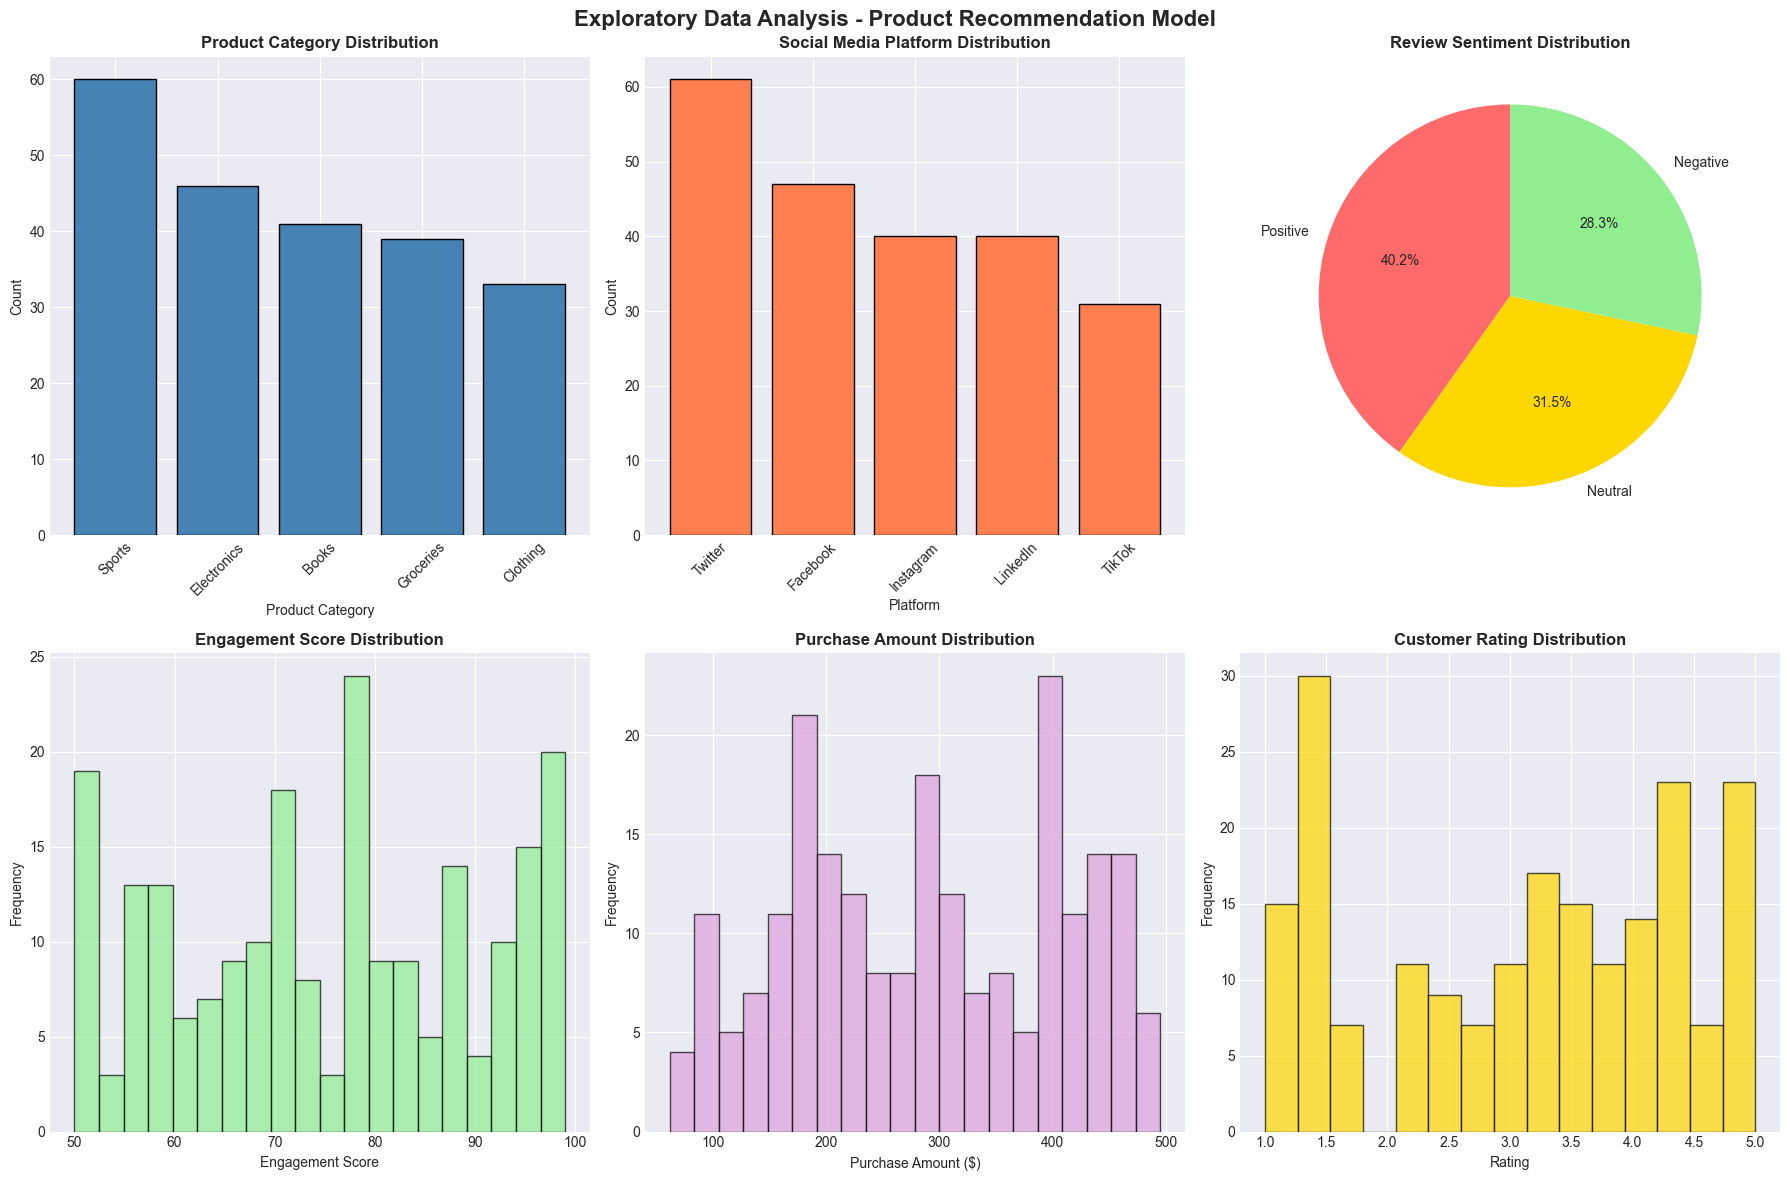

In [15]:
# ============================================================================
# 5. EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Display categorical distributions
display_categorical(df_merged)

# Dataset information
print("\n--- Dataset Information ---")
df_merged.info()

print("\n--- Statistical Summary ---")
display(df_merged.describe())

print("\n--- Missing Values ---")
print(df_merged.isnull().sum())

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis - Product Recommendation Model', 
             fontsize=16, fontweight='bold')

# Product category distribution
product_counts = df_merged['product_category'].value_counts()
axes[0, 0].bar(product_counts.index, product_counts.values, 
               color='steelblue', edgecolor='black')
axes[0, 0].set_title('Product Category Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Product Category')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Social media platform distribution
platform_counts = df_merged['social_media_platform'].value_counts()
axes[0, 1].bar(platform_counts.index, platform_counts.values, 
               color='coral', edgecolor='black')
axes[0, 1].set_title('Social Media Platform Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Platform')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Review sentiment distribution
sentiment_counts = df_merged['review_sentiment'].value_counts()
colors = ['#FF6B6B', '#FFD700', '#90EE90']
axes[0, 2].pie(sentiment_counts.values, labels=sentiment_counts.index, 
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 2].set_title('Review Sentiment Distribution', fontweight='bold')

# Engagement score distribution
axes[1, 0].hist(df_merged['engagement_score'], bins=20, 
                color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Engagement Score Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Engagement Score')
axes[1, 0].set_ylabel('Frequency')

# Purchase amount distribution
axes[1, 1].hist(df_merged['purchase_amount'], bins=20, 
                color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Purchase Amount Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Purchase Amount ($)')
axes[1, 1].set_ylabel('Frequency')

# Customer rating distribution
axes[1, 2].hist(df_merged['customer_rating'], bins=15, 
                color='gold', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Customer Rating Distribution', fontweight='bold')
axes[1, 2].set_xlabel('Rating')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# ============================================================================
# 6. DATA PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: DATA PREPROCESSING")
print("=" * 80)

# Initialize label encoder
le = LabelEncoder()

# Preprocess data
df_processed, numeric_cols = data_preprocessing(df_merged, le)

print("\n--- Processed Dataset Sample ---")
display(df_processed.head())

print(f"\nProcessed dataset shape: {df_processed.shape}")
print(f"\nNumeric columns for scaling:")
for col in numeric_cols:
    print(f"  - {col}")


STEP 3: DATA PREPROCESSING

--- Data Preprocessing ---

✓ Product Category Encoding:
  Books = 0
  Clothing = 1
  Electronics = 2
  Groceries = 3
  Sports = 4

--- Processed Dataset Sample ---


,purchase_amount,product_category,customer_rating,engagement_score,purchase_interest_score,review_sentiment,month,day,weekday,isweekend,social_media_platform_Facebook,social_media_platform_Instagram,social_media_platform_LinkedIn,social_media_platform_TikTok,social_media_platform_Twitter
0,408,4,2.3,61,1.3,1,1,1,0,0,0,0,0,1,0
1,408,4,2.3,72,1.6,1,1,1,0,0,0,0,0,0,1
2,408,4,2.3,82,3.6,0,1,1,0,0,0,0,0,0,1
3,332,2,4.2,60,4.3,2,1,2,1,0,0,1,0,0,0
4,442,2,2.1,87,4.8,0,1,3,2,0,1,0,0,0,0



Processed dataset shape: (219, 15)

Numeric columns for scaling:
  - purchase_amount
  - customer_rating
  - engagement_score
  - purchase_interest_score
  - month
  - day
  - weekday


In [17]:
# ============================================================================
# 7. TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: TRAIN-TEST SPLIT")
print("=" * 80)

X, y, X_train, X_test, y_train, y_test = prep_data(df_processed)

print(f"\nTarget distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"\nTarget distribution in test set:")
print(y_test.value_counts().sort_index())



STEP 4: TRAIN-TEST SPLIT

--- Train-Test Split ---
X_train shape: (175, 14)
X_test shape: (44, 14)
y_train shape: (175,)
y_test shape: (44,)

Target distribution in training set:
product_category
0    33
1    26
2    37
3    31
4    48
Name: count, dtype: int64

Target distribution in test set:
product_category
0     8
1     7
2     9
3     8
4    12
Name: count, dtype: int64


In [19]:
# ============================================================================
# 8. MODEL TRAINING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: MODEL TRAINING AND EVALUATION")
print("=" * 80)

# Store results
model_results = {}


STEP 5: MODEL TRAINING AND EVALUATION


In [20]:
# -------------------------
# 8.1 Vanilla Random Forest
# -------------------------
print("\n[1/5] Training Vanilla Random Forest...")
print("-" * 60)

rf_vanilla = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_vanilla.fit(X_train, y_train)
y_pred_rf_vanilla = rf_vanilla.predict(X_test)
y_proba_rf_vanilla = rf_vanilla.predict_proba(X_test)

rf_vanilla_accuracy = accuracy_score(y_test, y_pred_rf_vanilla)
rf_vanilla_f1 = f1_score(y_test, y_pred_rf_vanilla, average='weighted')
rf_vanilla_loss = log_loss(y_test, y_proba_rf_vanilla)

model_results['Random Forest (Vanilla)'] = {
    'model': rf_vanilla,
    'accuracy': rf_vanilla_accuracy,
    'f1_score': rf_vanilla_f1,
    'loss': rf_vanilla_loss
}

print(f"\n✓ Vanilla Random Forest Results:")
print(f"  Accuracy: {rf_vanilla_accuracy:.4f}")
print(f"  F1-Score: {rf_vanilla_f1:.4f}")
print(f"  Log Loss: {rf_vanilla_loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_vanilla, 
                          target_names=le.classes_))


[1/5] Training Vanilla Random Forest...
------------------------------------------------------------

✓ Vanilla Random Forest Results:
  Accuracy: 0.6591
  F1-Score: 0.6441
  Log Loss: 1.1128

Classification Report:
              precision    recall  f1-score   support

       Books       0.80      1.00      0.89         8
    Clothing       0.67      0.29      0.40         7
 Electronics       0.56      0.56      0.56         9
   Groceries       0.83      0.62      0.71         8
      Sports       0.56      0.75      0.64        12

    accuracy                           0.66        44
   macro avg       0.68      0.64      0.64        44
weighted avg       0.67      0.66      0.64        44




[2/5] Training Random Forest with GridSearchCV...
------------------------------------------------------------

Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

✓ GridSearch Random Forest Results:
  Accuracy: 0.7273
  F1-Score: 0.7045
  Log Loss: 1.1733

Classification Report:
              precision    recall  f1-score   support

       Books       0.80      1.00      0.89         8
    Clothing       1.00      0.29      0.44         7
 Electronics       0.80      0.89      0.84         9
   Groceries       0.80      0.50      0.62         8
      Sports       0.59      0.83      0.69        12

    accuracy                           0.73        44
   macro avg       0.80      0.70      0.70        44
weighted avg       0.77      0.73      0.70        44



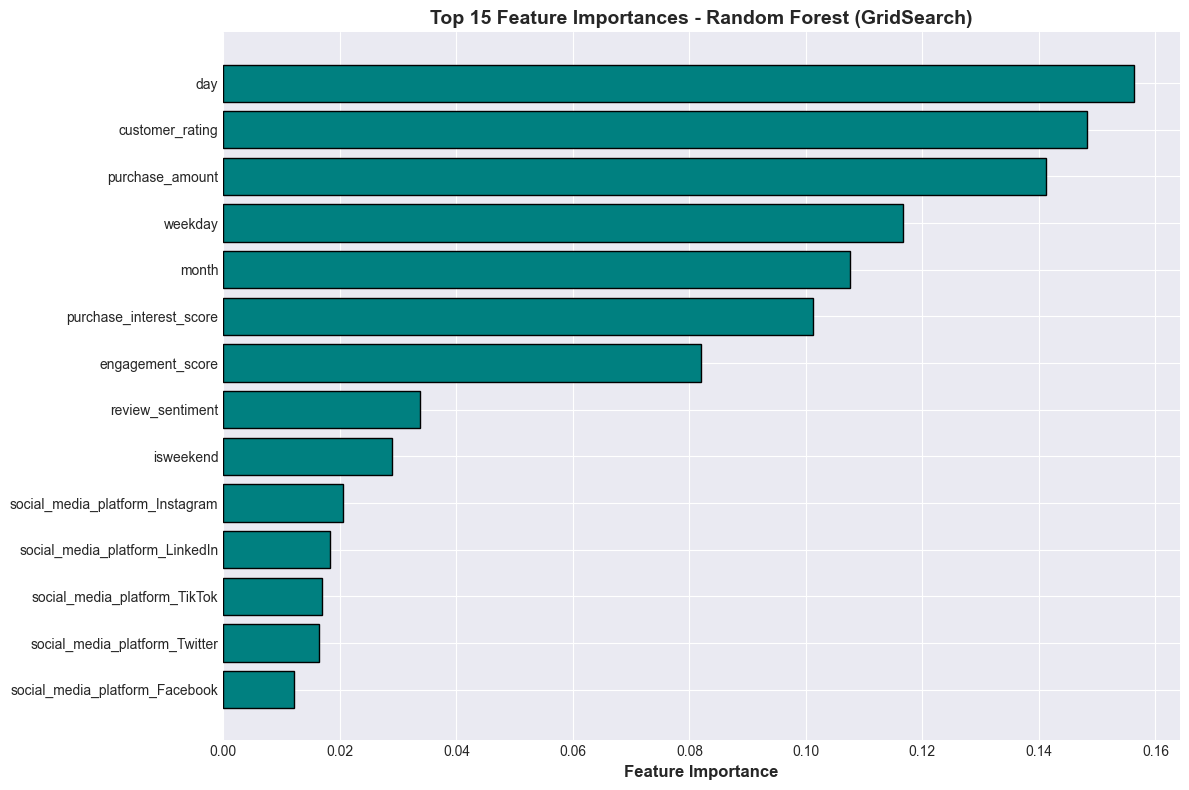

In [21]:
# -------------------------
# 8.2 Random Forest with GridSearchCV
# -------------------------
print("\n[2/5] Training Random Forest with GridSearchCV...")
print("-" * 60)

rf_grid_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 4, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(
    estimator=rf_grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

rf_grid.fit(X_train, y_train)
best_rf_grid = rf_grid.best_estimator_

print(f"\nBest Parameters: {rf_grid.best_params_}")

y_pred_rf_grid = best_rf_grid.predict(X_test)
y_proba_rf_grid = best_rf_grid.predict_proba(X_test)

rf_grid_accuracy = accuracy_score(y_test, y_pred_rf_grid)
rf_grid_f1 = f1_score(y_test, y_pred_rf_grid, average='weighted')
rf_grid_loss = log_loss(y_test, y_proba_rf_grid)

model_results['Random Forest (GridSearch)'] = {
    'model': best_rf_grid,
    'accuracy': rf_grid_accuracy,
    'f1_score': rf_grid_f1,
    'loss': rf_grid_loss
}

print(f"\n✓ GridSearch Random Forest Results:")
print(f"  Accuracy: {rf_grid_accuracy:.4f}")
print(f"  F1-Score: {rf_grid_f1:.4f}")
print(f"  Log Loss: {rf_grid_loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_grid, 
                          target_names=le.classes_))

# Feature importance visualization
importances = best_rf_grid.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(feat_df['Feature'].head(15), feat_df['Importance'].head(15), 
         color='teal', edgecolor='black')
plt.xlabel("Feature Importance", fontweight='bold', fontsize=12)
plt.title("Top 15 Feature Importances - Random Forest (GridSearch)", 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
# -------------------------
# 8.3 Random Forest with RandomizedSearchCV
# -------------------------
print("\n[3/5] Training Random Forest with RandomizedSearchCV...")
print("-" * 60)

rf_random_model = RandomForestClassifier(class_weight='balanced', random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

rf_random = RandomizedSearchCV(
    estimator=rf_random_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_random.fit(X_train, y_train)
best_rf_random = rf_random.best_estimator_

print(f"\nBest Parameters: {rf_random.best_params_}")

y_pred_rf_random = best_rf_random.predict(X_test)
y_proba_rf_random = best_rf_random.predict_proba(X_test)

rf_random_accuracy = accuracy_score(y_test, y_pred_rf_random)
rf_random_f1 = f1_score(y_test, y_pred_rf_random, average='weighted')
rf_random_loss = log_loss(y_test, y_proba_rf_random)

model_results['Random Forest (RandomizedSearch)'] = {
    'model': best_rf_random,
    'accuracy': rf_random_accuracy,
    'f1_score': rf_random_f1,
    'loss': rf_random_loss
}

print(f"\n✓ RandomizedSearch Random Forest Results:")
print(f"  Accuracy: {rf_random_accuracy:.4f}")
print(f"  F1-Score: {rf_random_f1:.4f}")
print(f"  Log Loss: {rf_random_loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_random, 
                          target_names=le.classes_))


[3/5] Training Random Forest with RandomizedSearchCV...
------------------------------------------------------------

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

✓ RandomizedSearch Random Forest Results:
  Accuracy: 0.7273
  F1-Score: 0.7045
  Log Loss: 1.1733

Classification Report:
              precision    recall  f1-score   support

       Books       0.80      1.00      0.89         8
    Clothing       1.00      0.29      0.44         7
 Electronics       0.80      0.89      0.84         9
   Groceries       0.80      0.50      0.62         8
      Sports       0.59      0.83      0.69        12

    accuracy                           0.73        44
   macro avg       0.80      0.70      0.70        44
weighted avg       0.77      0.73      0.70        44



In [23]:
# -------------------------
# 8.4 XGBoost Classifier
# -------------------------
print("\n[4/5] Training XGBoost Classifier with GridSearchCV...")
print("-" * 60)

xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y)),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=0
)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print(f"\nBest Parameters: {xgb_grid.best_params_}")

y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_loss = log_loss(y_test, y_proba_xgb)

model_results['XGBoost'] = {
    'model': best_xgb,
    'accuracy': xgb_accuracy,
    'f1_score': xgb_f1,
    'loss': xgb_loss
}

print(f"\n✓ XGBoost Results:")
print(f"  Accuracy: {xgb_accuracy:.4f}")
print(f"  F1-Score: {xgb_f1:.4f}")
print(f"  Log Loss: {xgb_loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=le.classes_))


[4/5] Training XGBoost Classifier with GridSearchCV...
------------------------------------------------------------


/Users/edine.mugisha/Documents/School/echoFace/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edine.mugisha/Documents/School/echoFace/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edine.mugisha/Documents/School/echoFace/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:23:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edine.mugisha/Documents/School/echoFace/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:23:05] WARNING: /Users/runner/work/xgboost/xgboost


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}

✓ XGBoost Results:
  Accuracy: 0.7045
  F1-Score: 0.6835
  Log Loss: 1.0424

Classification Report:
              precision    recall  f1-score   support

       Books       0.73      1.00      0.84         8
    Clothing       0.67      0.29      0.40         7
 Electronics       0.70      0.78      0.74         9
   Groceries       1.00      0.50      0.67         8
      Sports       0.62      0.83      0.71        12

    accuracy                           0.70        44
   macro avg       0.74      0.68      0.67        44
weighted avg       0.73      0.70      0.68        44



In [28]:
# -------------------------
# 8.5 Logistic Regression
# -------------------------
print("\n[5/5] Training Logistic Regression...")
print("-" * 60)

# First, let's check for NaN values in the original data
print("\n--- Debugging NaN Values ---")
print(f"NaN count in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN count in X_test: {X_test.isnull().sum().sum()}")

if X_train.isnull().sum().sum() > 0:
    print("\nColumns with NaN values in X_train:")
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

# Fill NaN values before scaling
X_train_clean = X_train.fillna(0)
X_test_clean = X_test.fillna(0)

print(f"\n✓ NaN values filled with 0")
print(f"NaN count after filling: {X_train_clean.isnull().sum().sum()}")

# Now scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

print(f"✓ Scaling completed")

# Train logistic regression
logreg = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000, 
    random_state=42
)
logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_test_scaled)
y_proba_logreg = logreg.predict_proba(X_test_scaled)

logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg, average='weighted')
logreg_loss = log_loss(y_test, y_proba_logreg)

model_results['Logistic Regression'] = {
    'model': logreg,
    'accuracy': logreg_accuracy,
    'f1_score': logreg_f1,
    'loss': logreg_loss
}

print(f"\n✓ Logistic Regression Results:")
print(f"  Accuracy: {logreg_accuracy:.4f}")
print(f"  F1-Score: {logreg_f1:.4f}")
print(f"  Log Loss: {logreg_loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg, 
                          target_names=le.classes_))


[5/5] Training Logistic Regression...
------------------------------------------------------------

--- Debugging NaN Values ---
NaN count in X_train: 13
NaN count in X_test: 6

Columns with NaN values in X_train:
customer_rating    13
dtype: int64

✓ NaN values filled with 0
NaN count after filling: 0
✓ Scaling completed

✓ Logistic Regression Results:
  Accuracy: 0.2273
  F1-Score: 0.2200
  Log Loss: 1.7376

Classification Report:
              precision    recall  f1-score   support

       Books       0.33      0.38      0.35         8
    Clothing       0.10      0.14      0.12         7
 Electronics       0.27      0.33      0.30         9
   Groceries       0.25      0.25      0.25         8
      Sports       0.17      0.08      0.11        12

    accuracy                           0.23        44
   macro avg       0.22      0.24      0.23        44
weighted avg       0.22      0.23      0.22        44

